<a href="https://colab.research.google.com/github/YichiRockyZhang/Face-Recogniton-CMSC472-Final-Project/blob/main/Facial_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Verification Binary Classifier

Name:  **Erik Kelemen, Daniel Gao, Yichi Zhang, Naga Nageswaren, Ashish Manda**  
Group: **Facial Recognition Group**

Link to Google Drive : **https://colab.research.google.com/drive/1HloPmg2NdLmXcCpRPS5qcaLezRQ7oW6X?usp=sharing**



**Table of Contents:**<br>
1. Load data from the CelebA and LFW (Labelled Faces In The Wild) Datasets<br>
2. Instantiate Dataloader with automated Triplet Generation<br>
3. Apply SiameseNN with Triplet Loss Function<br>
4. (Moonshot) Improve performance of siamese neural network beyond the performance accuracy of FaceNet ()<br>
5. Automate Graph Generation (can easily recycle code from P3 or P4)<br>
6. Writeup -- Results Analysis, explanation of code... (markdown cells, explain each step)**



# Part 1: Loading the Labeled Faces in the Wild (LFW) dataset and the CelebA datadest.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import scipy
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from skimage.transform import resize
from skimage.color import rgb2gray

import pandas as pd
import random
import csv


Dataset loaded from: https://www.kaggle.com/jessicali9530/lfw-dataset
1. Download kaggle.json from the group folder to your local machine. 
2. Run the code block below.
3. Upload kaggle.json when prompted.


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# To download LFW dataset
! kaggle datasets download -d jessicali9530/lfw-dataset
! mkdir LFW
! unzip lfw-dataset.zip -d LFW

# To download CelebA dataset
! kaggle datasets download -d jessicali9530/celeba-dataset
! unzip celeba-dataset.zip -d CelebA
! rm -rf celeba-dataset.zip lfw-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba/197617.jpg  
  inflating

Try to download the cropped and resized images from CelebA from [here](https://drive.google.com/file/d/1jklUKdmdNixZ5voLOyAChrb_AtfYwLUs/view?usp=sharing) by running the cell below.

In [ ]:
! pip install gdown
! gdown https://drive.google.com/uc?id=1jklUKdmdNixZ5voLOyAChrb_AtfYwLUs
! unzip resized.zip -d CelebA/img_align_celeba/
! gdown https://drive.google.com/uc?id=1tAj_dqgm7qHQd1T0NE_rS9fp655j_z8j
! sed 's/ \+/,/g' list_identity_celeba.txt > CelebA/list_identity_celeba.csv && rm list_identity_celeba.txt
! rm -f resized.zip
! ls CelebA/img_align_celeba/img_align_celeba_resized | wc -l && echo -n " resized images from CelebA have been downloaded successfully."

Streaming output truncated to the last 5000 lines.
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/181296.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/003188.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/138456.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/011369.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/022435.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/082112.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/152617.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/143953.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/024528.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/124869.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/146993.jpg  
  inflating: CelebA/img_align_celeba/img_align_celeba_resized/067052.jpg  
  inflating: CelebA/img_align_celeba/img_align_ce

If the download fails, use the command below to crop the images from CelebA (est. 2 hours).

In [ ]:
# ! sudo apt install imagemagick
# ! mkdir CelebA/img_align_celeba/img_align_celeba_resized
# ! for i in CelebA/img_align_celeba/img_align_celeba/*.jpg;do echo "$i" | cut -d '/' -f 4 && convert "$i" -resize 250x250 -background black -gravity center -extent 250x250 "CelebA/img_align_celeba/img_align_celeba_resized/$(echo "$i" | cut -d '/' -f 4)";done

Verify the resized CelebA images were successfully downloaded by running the below cell. You should see two images, one with and one without black bars. 

Anchor and Positive (same person)


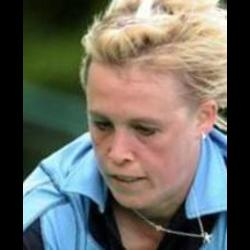

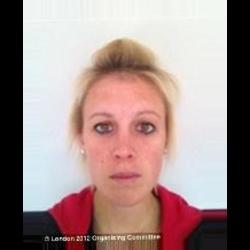

In [ ]:
from IPython.display import Image, display
# display(Image('CelebA/img_align_celeba/img_align_celeba/028768.jpg')) # original image
# display(Image('CelebA/img_align_celeba/img_align_celeba_resized/028768.jpg')) # resized to 250x250

print('Anchor and Positive (same person)')
display(Image('CelebA/img_align_celeba/img_align_celeba_resized/008073.jpg'))
display(Image('CelebA/img_align_celeba/img_align_celeba_resized/011233.jpg'))

Generating a list of triplets:

In [ ]:
import pandas as pd

# Training 000000.jpg to 162770.jpg
# Validation 162771.jpg to 182637.jpg
# Testing 182638.jpg to 202599.jpg

iden_df = pd.read_csv('CelebA/list_identity_celeba.csv', header=None)
train_map, val_map, test_map = {}, {}, {}
for index, row in iden_df.iterrows():
  img_name, id = row[0], row[1]
  if img_name <= '162770.jpg': #images for training according to list_eval_partition
    if id not in train_map:
      train_map[id] = [img_name]
    else:
      train_map[id].append(img_name)
  elif '162770.jpg' < img_name and img_name <= '182637.jpg':
    if id not in val_map:
      val_map[id] = [img_name]
    else:
      val_map[id].append(img_name)
  else:
    if id not in test_map:
      test_map[id] = [img_name]
    else:
      test_map[id].append(img_name)
print(f'There are {len(train_map)} different identities for training.')
print(f'There are {len(val_map)} different identities for validation.')
print(f'There are {len(test_map)} different identities for testing.')

There are 8192 different identities for training.
There are 985 different identities for validation.
There are 1000 different identities for testing.


Generate a list of potential triplets:

1000 triplets generated
100 triplets generated
100 triplets generated


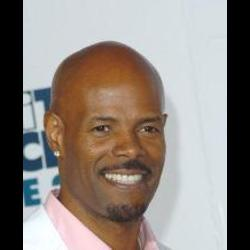

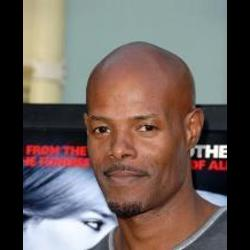

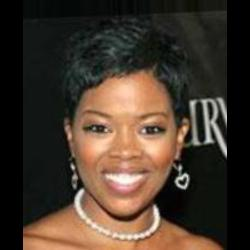

In [ ]:
from random import randint, choice, sample
random.seed()

def generate_triplet_list(num_triplets, mode='train'):
  triplet_list = []

  if mode == 'train':
    num_identities = len(train_map)
    id2imgs = train_map
  elif mode == 'val':
    num_identities = len(val_map)
    id2imgs = val_map
  else:
    num_identities = len(test_map)
    id2imgs = test_map

  for i in range(num_triplets):
    anchor_idx, negative_idx = sample(id2imgs.keys(), 2)
    # Ensure the person specified by anchor_idx has more than one picture
    while len(id2imgs[anchor_idx]) < 2:
      anchor_idx, negative_idx = sample(id2imgs.keys(), 2)
    # print(f'{anchor_idx}, {negative_idx}')
    anchor, positive = sample(id2imgs[anchor_idx], 2)
    [negative] = sample(id2imgs[negative_idx], 1)
    triplet_list.append((anchor, positive, negative))

  print(f'{len(triplet_list)} triplets generated')
  return triplet_list
#Cut 20 fold, initial values (1000,100,100)
train_list = generate_triplet_list(1000, mode='train')
val_list = generate_triplet_list(100, mode='val')
test_list = generate_triplet_list(100, mode='test')

# Show sample triplet:
a, p, n = train_list[0]
display(Image('CelebA/img_align_celeba/img_align_celeba_resized/' + a))
display(Image('CelebA/img_align_celeba/img_align_celeba_resized/' + p))
display(Image('CelebA/img_align_celeba/img_align_celeba_resized/' + n))

Creating a Dataset class for CelebA:

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, mode = 'train'):
        self.mode = mode #'train', 'val', 'test']

        if self.mode == 'train':
          self.triplets = train_list
        elif self.mode == 'val':
          self.triplets = val_list
        else:
          self.triplets = test_list

    def __len__(self):
        ## TODO: Return number of images in the dataset
        length = 0
        if self.mode == 'train':
          length = len(train_list)
        elif self.mode == 'val':
          length = len(val_list)
        else:
          length = len(test_list)
        return length
    
    def __getitem__(self, idx):
        anc_file, pos_file, neg_file = self.triplets[idx]

        a = torch.tensor(mpimg.imread(f'CelebA/img_align_celeba/img_align_celeba_resized/{anc_file}'))
        p = torch.tensor(mpimg.imread(f'CelebA/img_align_celeba/img_align_celeba_resized/{pos_file}'))
        n = torch.tensor(mpimg.imread(f'CelebA/img_align_celeba/img_align_celeba_resized/{neg_file}'))

        if a.shape == (250, 250): a = a.view(250, 250, 1).expand(-1, -1, 3)
        if p.shape == (250, 250): p = p.view(250, 250, 1).expand(-1, -1, 3)
        if n.shape == (250, 250): n = n.view(250, 250, 1).expand(-1, -1, 3)

        a = a.reshape(3, 250, 250); p = p.reshape(3, 250, 250); n = n.reshape(3, 250, 250)
        a = a/255; p = p/255; n = n/255  
        return {'image': (a, p, n)}

Dataloader for CelebA:

Now, use the .csv files to pull some groups of matching and mismatching faces. The .csv's are divided into individual and paired paradigms -- for now, we will follow the paired (matching vs. mismatching) sets and easily generate groups of images that we know are matches or mismatches. We will use pandas to store these csv's as DataFrames for ease of access.

In [ ]:
def plot_image(im,title,cv2 = True):
    plt.figure()
    plt.imshow(im)
    plt.title(title)

Index(['name', 'imagenum1', 'imagenum2'], dtype='object')
Index(['name', 'imagenum1', 'imagenum2'], dtype='object')
Index(['name', 'imagenum1', 'name.1', 'imagenum2'], dtype='object')
Index(['name', 'imagenum1', 'name.1', 'imagenum2'], dtype='object')
Aaron_Peirsol
<class 'pandas.core.series.Series'>
Aaron_Peirsol
<class 'pandas.core.series.Series'>
Aaron_Sorkin
<class 'pandas.core.series.Series'>
Abdel_Nasser_Assidi
<class 'pandas.core.series.Series'>
Abdullah
<class 'pandas.core.series.Series'>


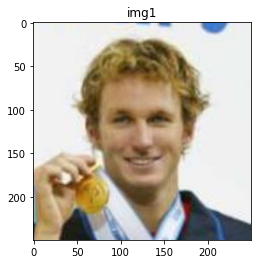

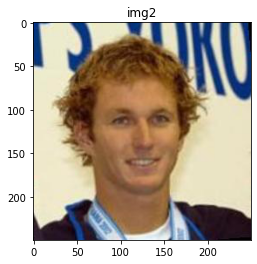

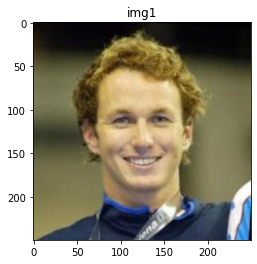

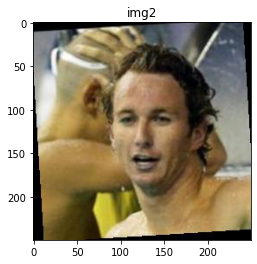

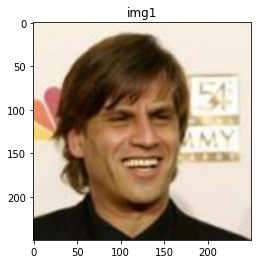

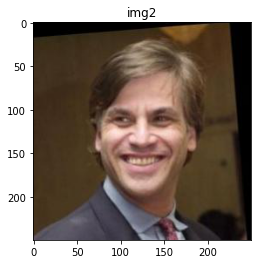

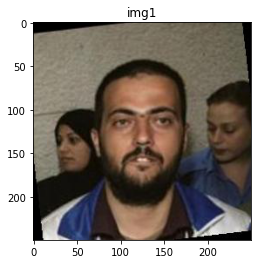

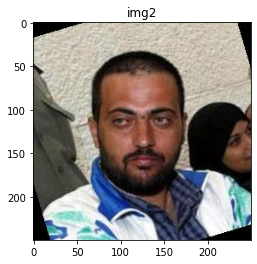

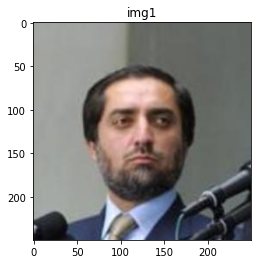

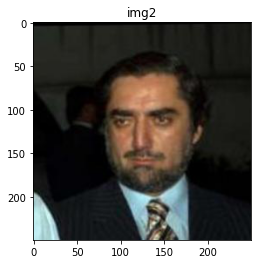

In [ ]:
match_train = pd.read_csv('LFW/matchpairsDevTrain.csv')
mismatch_train = pd.read_csv('LFW/mismatchpairsDevTrain.csv')
match_test = pd.read_csv('LFW/matchpairsDevTest.csv')
mismatch_test = pd.read_csv('LFW/mismatchpairsDevTest.csv')

print(match_train.columns)
print(match_test.columns)
print(mismatch_test.columns)
print(mismatch_test.columns)

#given a name "firstname_lastname", image_num, return the .jpeg path associated with it
def get_path(name, num, dataset='LFW'):
  return f'LFW/lfw-deepfunneled/lfw-deepfunneled/{name}/{name}_{num:04}.jpg'

def get_img(name, num):
  return mpimg.imread(get_path(name, num))

for ind, row in match_train[:5].iterrows():
  print(row['name'])
  print(type(row))
  img1 = get_img(row['name'], row['imagenum1'])
  img2 = get_img(row['name'], row['imagenum2'])
  plot_image(img1, 'img1')
  plot_image(img2, 'img2')

Now let's see some mismatches.

AJ_Cook
<class 'pandas.core.series.Series'>
Aaron_Sorkin
<class 'pandas.core.series.Series'>
Abdel_Nasser_Assidi
<class 'pandas.core.series.Series'>
Abdoulaye_Wade
<class 'pandas.core.series.Series'>
Abdul_Rahman
<class 'pandas.core.series.Series'>


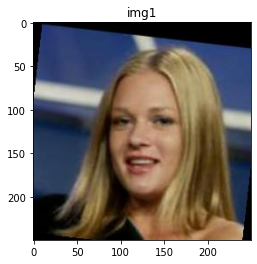

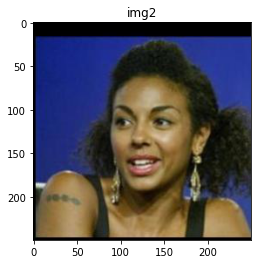

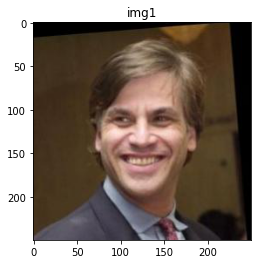

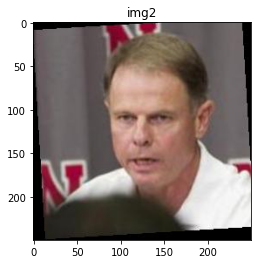

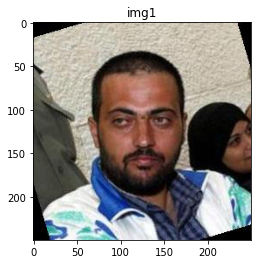

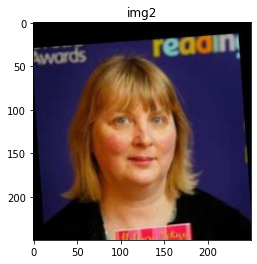

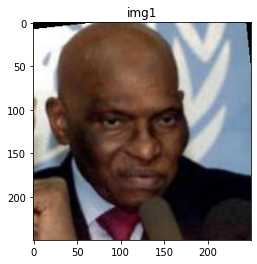

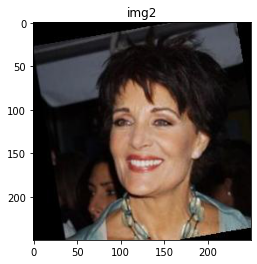

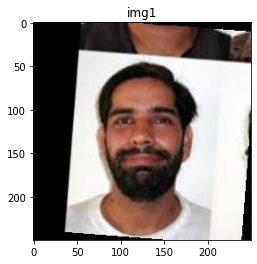

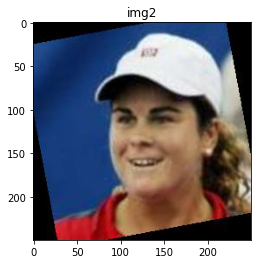

In [ ]:
for ind, row in mismatch_train[:5].iterrows():
  print(row['name'])
  print(type(row))
  img1 = get_img(row['name'], row['imagenum1'])
  img2 = get_img(row['name.1'], row['imagenum2'])
  plot_image(img1, 'img1')
  plot_image(img2, 'img2')

#Part 2: Data Loader and Data Augmentation



Code for converting .jpg to tensors for input for .pth. 
All images are 250x250 .jpg format.
We need to convert lfw-deepfunneled to a .pth file.


If we are going to grayscale, do so by calling the appropriate function below.


In [ ]:
def jpgToGrayscaleTensor(inp_jpg):
  return torch.tensor(rgb2gray(inp_jpg))##.flatten()
def jpgToTensor(inp_jpg): #Converts a single .jpg to a tensor 
  return torch.tensor(inp_jpg)##.flatten()

This is only defined for k=2. 


In [ ]:
# Goal: Generate a .pth to use LFW for testing (as is standard in industry)

data = {}
match_tr, match_te, mismatch_tr, mismatch_te = [], [], [], []
#Need to write these img's into a .pth now, and we will finally have our data ready 

for ind, row in match_test.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name'], row['imagenum2']))
  match_te.append([img1,img2])

for ind, row in mismatch_test.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name.1'], row['imagenum2']))
  mismatch_te.append([img1,img2])

#We need to merge the two arrays together, and then shuffle them...
images = match_te + mismatch_te
labels = [1] * len(match_te) + [0] * len(mismatch_te)

#Now, to shuffle these arrays... in unison
#Can somebody double check that the below three lines work expectedly?
c = list(zip(images, labels))
random.shuffle(c)
images, labels = zip(*c)

#Now, to take the first half for training, next half for validation, and we are done
#This can be easily changed for different portions, just modify mid. 
#Can take last 1/10th for val, first 9/10th for testing, very easily
data['test_images'], data['test_labels'] = images, labels

torch.save(data, "LFWdataset.pth")

#Double check dimensions, should all be equal
print(len(data['test_images']))
print(len(data['test_labels']))

1000
1000


Valid Modes: match_train, mismatch_train, match_test, mismatch_test
<br>
match labels -> 1 (all k images ARE the same person)<br>
mismatch labels -> 0 (not all k images are the same person)

In [ ]:
class LFWDataset(Dataset):
    #mode can be 'train', 'val', or 'test'
    def __init__(self, file_name, mode = 'test'):
        if mode == 'train' or mode == 'val':
            print('Do not run in non-testing modes')
            raise Exception('ERROR: This dataloader was written only to be used as a testing set')

        self.file_name = file_name
        self.mode = mode
        
        dataset = torch.load(file_name)
        self.data = dataset[mode + '_images']
        self.len = len(self.data)
        self.labels = dataset[mode + '_labels']

    def __len__(self):
      ## TODO: Return number of images in the dataset
      return self.len
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        #print(self.data[idx])
        img1, img2 = self.data[idx]
        img = img1.reshape(3,250,250)/255, img2.reshape(3,250,250)/255
        #print(self.labels[idx])
        return img, self.labels[idx]


In [ ]:
batch_size = 8
train_set = CelebADataset(mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,drop_last=True)
val_set = CelebADataset(mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False,drop_last=True)
test_set = CelebADataset(mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,drop_last=True)

LFW_test_set = LFWDataset('LFWdataset.pth', mode='test')
LFW_test_dataloader = torch.utils.data.DataLoader(LFW_test_set,
                                          batch_size=batch_size, shuffle=False)

125

#Part 3: Siamese Neural Network
---



The model must be given k images -- for now, limit to k=2. Returns a BINARY ANSWER (sigmoid last act. function + rounding) -- are they k-images all of the same person or not? 
<br>Question: How should the NN be fed data to interpret multiple images? 
<br>Answer: NN must be trained on groups of images -- if every image in the group is of the same person, then label 1. Else, label 0. 

We tried to derive inspiration from external sources of Siamese networks. However, we ran into trouble getting our input to work with the model, so we had to modify convolution layers and some operations such as batctchNorm.

In [ ]:
import torch.nn as nn
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2,padding=1),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2,padding=1),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, stride=2)
            )
            

        self.fc = nn.Sequential(
            nn.Linear(131072, 1024),#10x492032
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024))
    

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2, input3):
        a = self.forward_once(input1)
        p = self.forward_once(input2)
        n = self.forward_once(input3)
        return a, p, n

Skeleton taken from project 3, should probably be converted to cuda.

Define Hyperparameters (To be optimized...):


In [ ]:
learning_rate = 0.001
epochs = 50
threshold = 55 #<-- FaceNet model used 1.242

In [ ]:
model = SiameseNetwork()  #making an instance of the network
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)  #model.paramters() gives all the trainable paramters. 
loss_function = nn.BCELoss() # -> change

In [ ]:
len(train_set)

1000

X is a tensor of (B * 250x250x3) -> this is NCHW in pytorch<br>
y is a tensor of (B) 0 or 1's



Distance function will be torch.cdist(x1, x2, p-norm)<br>
Loss function will be nn.TripletMarginWithDistanceLoss<br>
I will try to implement the online triplet mining from scratch first by sorting for the top 5 hardest triplets in the current mini-batch


I think that it only makes sense for us to compute accuracy during validation and testing, not training -- accuracy will be defined as #Correct Classifications / Total Classifications. In Validation and Testing, show PAIRS of Images; compute distance between embeddings; threshold and return binary answer (0 or 1). 

From Assignment 5, print the progress so we have an estimate for how long training will take.

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
plot_train_loss = []
plot_val_loss, val_acc, plot_val_acc = [], [], []
anchor_to_positive = []
anchor_to_negative = []
start = time.time()
epochs = 50 #used to be 50
for i in range(1, epochs+1):
  train_loss, val_loss = [], []
  model.train()
  for batch in enumerate(train_dataloader):
    #print(batch[1]['image'][1].shape)
    anchors, positives, negatives = batch[1]['image']
    #B*3*250*250
    anchors = anchors.type(torch.cuda.FloatTensor)
    positives = positives.type(torch.cuda.FloatTensor)
    negatives = negatives.type(torch.cuda.FloatTensor)

    #model_a, model_p, model_n = model(anchors, positives, negatives)
    model_a, model_p, model_n = model.forward(anchors, positives, negatives)

    pdist = nn.PairwiseDistance(p=2)
 
    loss_fn = nn.TripletMarginWithDistanceLoss(margin=0.2,reduction='none')
    loss = loss_fn(model_a,model_p,model_n)
    t_3, _ = torch.topk(loss,3) #was 5
    mean_loss = torch.mean(t_3)
    mean_loss_number = mean_loss.item()
    #print("mean training loss " + str(mean_loss.item()))
    train_loss.append(mean_loss_number)
    optimizer.zero_grad()
    mean_loss.backward()
    optimizer.step()
  plot_train_loss.append(sum(train_loss)/len(train_loss))

  print("Epoch: " + str(i) + " || time elapsed: " + str(time.time()-start))
  
  model.eval()

  for batch in enumerate(val_dataloader):
    anchors, positives, negatives = batch[1]['image']

    anchors = anchors.type(torch.cuda.FloatTensor)

    pos_np = positives.detach().numpy()
    neg_np = negatives.detach().numpy()
    matches_np = np.concatenate((pos_np[0:int(batch_size/2)], neg_np[0:int(batch_size/2)]), axis=0)
    labels = [1]*int(batch_size/2) + [0]*int(batch_size/2) #[1,1,1,1,0,0,0,0]

    matches = torch.from_numpy(matches_np)
    matches = matches.type(torch.cuda.FloatTensor)

    model_anchor = model.forward_once(anchors)
    model_matches = model.forward_once(matches)

    pdist = nn.PairwiseDistance(p=2)
    prediction = pdist(model_anchor, model_matches) 
    # print("distances between embeddings:")
    # print(prediction)
    prediction = prediction.detach().cpu().numpy() < threshold
    #print(prediction)

    for i in range(len(labels)):
      if prediction[i] == labels[i]:
        val_acc.append(1)
      else:
        val_acc.append(0)
  plot_val_acc.append(np.sum(val_acc)/len(val_acc))

Epoch: 1 || time elapsed: 35.74827814102173
Epoch: 2 || time elapsed: 71.95760750770569
Epoch: 3 || time elapsed: 108.276850938797
Epoch: 4 || time elapsed: 144.7396535873413
Epoch: 5 || time elapsed: 181.01495265960693
Epoch: 6 || time elapsed: 217.35860013961792
Epoch: 7 || time elapsed: 253.50329089164734
Epoch: 8 || time elapsed: 289.8183708190918
Epoch: 9 || time elapsed: 326.09902238845825
Epoch: 10 || time elapsed: 362.45790433883667
Epoch: 11 || time elapsed: 398.7493450641632
Epoch: 12 || time elapsed: 435.0333676338196
Epoch: 13 || time elapsed: 471.29619550704956
Epoch: 14 || time elapsed: 507.7145085334778
Epoch: 15 || time elapsed: 543.8477118015289
Epoch: 16 || time elapsed: 580.2749309539795
Epoch: 17 || time elapsed: 616.5920739173889
Epoch: 18 || time elapsed: 652.7370624542236
Epoch: 19 || time elapsed: 688.9549524784088
Epoch: 20 || time elapsed: 725.301519870758
Epoch: 21 || time elapsed: 761.5257134437561
Epoch: 22 || time elapsed: 797.6531147956848
Epoch: 23 || ti

In [ ]:
dist_same= []
dist_diff = []
CA_test_acc, CA_plot_test_acc = [], []
LFW_test_acc, LFW_plot_test_acc = [], []
test_anchor_pos = []
test_anchor_neg = []
for batch in enumerate(test_dataloader):
    anchors, positives, negatives = batch[1]['image']

    anchors = anchors.type(torch.cuda.FloatTensor)

    pos_np = positives.detach().numpy()
    neg_np = negatives.detach().numpy()
    matches_np = np.concatenate((pos_np[0:int(batch_size/2)], neg_np[0:int(batch_size/2)]), axis=0)
    labels = [1]*int(batch_size/2) + [0]*int(batch_size/2) #[1,1,1,1,0,0,0,0]

    matches = torch.from_numpy(matches_np)
    matches = matches.type(torch.cuda.FloatTensor)

    model_anchor = model.forward_once(anchors)
    model_matches = model.forward_once(matches)

    pdist = nn.PairwiseDistance(p=2)
    prediction = pdist(model_anchor, model_matches) 
    # prediction = prediction.detach().cpu().numpy() < threshold
    prediction = prediction.detach().cpu().numpy() < 55
    # print(prediction)
    # print(labels)

    for i in range(len(labels)):
      if prediction[i] == labels[i]:
        CA_test_acc.append(1)
      else:
        CA_test_acc.append(0)
CA_plot_test_acc.append(np.sum(CA_test_acc)/len(CA_test_acc))

for batch_i, (pairs, labels) in enumerate(LFW_test_dataloader):
 # pairs, labels = batch['image']
  anchors, matches = pairs
  anchors = matches.type(torch.cuda.FloatTensor)
  matches = matches.type(torch.cuda.FloatTensor)
  model_anchor = model.forward_once(anchors)
  model_match = model.forward_once(matches)

  pdist = nn.PairwiseDistance(p=2)
  prediction = pdist(model_anchor, model_matches) 
  #prediction = prediction.detach().cpu().numpy() < threshold
  
  prediction = prediction.detach().cpu().numpy() < 55
  labels = labels.detach().cpu().numpy()
  # print(prediction)
  # print(labels)
  labels = labels.tolist()
  for i in range(len(labels)):
    if prediction[i] == labels[i]: #runs if true
      LFW_test_acc.append(1)
      #dist_same.extend(prediction)
    else:
      LFW_test_acc.append(0)
      #dist_diff.extend(prediction)
LFW_plot_test_acc.append(np.sum(LFW_test_acc)/len(LFW_test_acc))


#Part 6: Graphs, Visualization, and Analysis

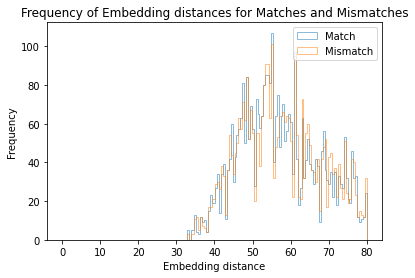

In [ ]:
bins = np.linspace(0, 80, 160)

plt.hist(dist_same, bins, alpha=0.5, label='Match',histtype='step')
plt.hist(dist_diff, bins, alpha=0.5, label='Mismatch',histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Embedding distance')
plt.legend(loc='upper right')
plt.title("Frequency of Embedding distances for Matches and Mismatches")
plt.show()

# plt.plot(dist_same)
# plt.ylabel('SAME DISTANCES')
# plt.xlabel('# triplets')
# plt.show()
# plt.plot(dist_diff)
# plt.ylabel('DIFFERENT DISTANCES')
# plt.xlabel('# triplets')
# plt.show()
# plt.scatter(dist_same,dist_diff)
# plt.xlabel('ANCHOR TO POSITIVE PAIRWISE DISTANCE')
# plt.ylabel('ANCHOR TO NEGATIVE PAIRWISE DISTANCE')
# plt.legend()
# plt.show()

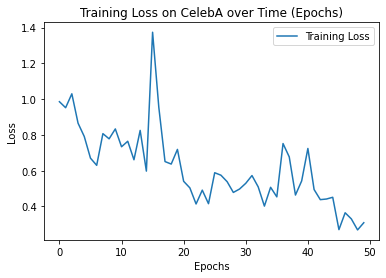

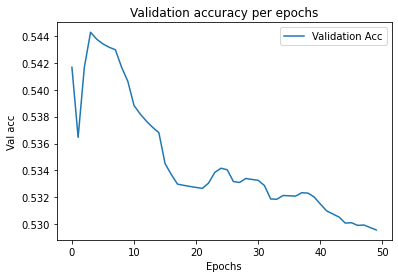

In [ ]:
#TRAINING LOSS AND VALIDATION LOSS ON CALEBA
plt.plot(plot_train_loss, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss on CelebA over Time (Epochs)")
plt.legend()
plt.show()



plt.plot(plot_val_acc, label = 'Validation Acc')
plt.ylabel('Val acc')
plt.title("Validation accuracy per epochs")
plt.xlabel('Epochs')
plt.legend()
plt.show()



In [ ]:
print("FINAL CELEBA TEST ACCURACY:")
print(CA_plot_test_acc)
print("FINAL LFW TEST ACCURACY:")
print(LFW_plot_test_acc)

CELEBA TEST ACCURACY:
[0.5625]
LFW TEST ACCURACY:
[0.512]
